In [1]:
import pandas as pd
import numpy as np
from random import randint

# Preprocessor

In [2]:
class Preprocessor:
    '''
    處理器相關物件建立, 並以靜態方法(@staticmethod)存在, 主要有
    (1)資料前處理器 (DataPreprocessor)
    (2)Z-Score正規化轉換器 (StandardScalar)
    (3)最大最小值正規化轉換器(MinMaxScalar)
    警告:
    此物件與Data物件高度耦合 
    '''
    #資料前處理器
    @staticmethod
    def DataPreprocessor(data):
        df = data.copy()
        df.drop(columns = ["病例編號","ICROP"], inplace = True)
        
        category_cols = ["呼吸器使用", "(FiO2)氧氣濃度", "是否得到ROP"]
        for col in category_cols:
            df[col] = df[col].astype("category").cat.codes
            
        normalized_cols = ['妊娠週數', '出生體重', '血色素', '加護病房住院天數', '氧氣使用天數',
                           
                           "呼吸器使用", "(FiO2)氧氣濃度", "Apgar score計分"]
        for col in normalized_cols:
            df[col] = Preprocessor.MinMaxScalar(df[col])
        
        
        return df
    
    # Z-Score正規化轉換器
    @staticmethod
    def StandardScalar(Series): 
        
        _mean = Series.mean()
        _std = Series.std()
        
        return Series.apply(lambda value: (value - _mean) / _std)
    
    #最大最小值正規化轉換器
    @staticmethod
    def MinMaxScalar(Series):
        _max = Series.max()
        _min = Series.min()
        
        return Series.apply(lambda value:(value - _min) / (_max - _min))
        
        

class Data:
    '''
    存放原始資料之物件
    警告:
    此物件與Preprocessor物件高度耦合
    '''
    def __init__(self, file_name):
        self._data = pd.read_excel(file_name)
        
        self.PSO_data = Preprocessor.DataPreprocessor(self._data).drop(columns = ["妊娠週數", "(FiO2)氧氣濃度", "Apgar score計分"])
        self.CE_data = Preprocessor.DataPreprocessor(self._data).drop(columns = ["加護病房住院天數", "血色素"])


In [3]:
data = Data(file_name= "視網膜.xls")
data.PSO_data

,出生體重,血色素,加護病房住院天數,氧氣使用天數,呼吸器使用,是否得到ROP
0,0.000000,0.450000,0.884615,0.457143,1.0,1
1,0.040495,0.664286,0.721154,0.128571,1.0,0
2,0.040495,0.335714,1.000000,0.714286,1.0,1
3,0.040495,0.335714,1.000000,0.900000,1.0,1
4,0.044994,0.850000,0.884615,0.742857,1.0,1
...,...,...,...,...,...,...
338,0.991001,0.585714,0.048077,0.014286,1.0,0
339,0.991001,0.514286,0.019231,0.028571,1.0,0
340,0.999438,0.292857,0.019231,0.014286,1.0,0
341,0.999438,0.492857,0.057692,0.057143,1.0,0


In [4]:
data.CE_data

,妊娠週數,出生體重,氧氣使用天數,呼吸器使用,(FiO2)氧氣濃度,Apgar score計分,是否得到ROP
0,0.166667,0.000000,0.457143,1.0,0.0,0.125,1
1,0.583333,0.040495,0.128571,1.0,0.5,0.625,0
2,0.083333,0.040495,0.714286,1.0,0.0,0.625,1
3,0.083333,0.040495,0.900000,1.0,0.0,0.625,1
4,0.333333,0.044994,0.742857,1.0,0.0,0.125,1
...,...,...,...,...,...,...,...
338,0.916667,0.991001,0.014286,1.0,0.5,0.875,0
339,1.000000,0.991001,0.028571,1.0,0.5,0.875,0
340,1.000000,0.999438,0.014286,1.0,0.5,0.625,0
341,1.000000,0.999438,0.057143,1.0,0.5,0.875,0


In [5]:
class ParameterGrid:
    def __init__(self, SVM_data, BPNN_data):
        '''
        網格搜索法的參數網格物件, 需傳入SVM跟BPNN的資料來查看特徵數(欄位數)
        '''
        self._SVM_number_of_features = len(SVM_data.columns) - 1 
        self._BPNN_number_of_features = len(BPNN_data.columns) - 1 
    
    
    @property
    def SVM_ParameterGrid(self):
        '''
        根據SVM資料, 計算出RBF Gamma並設定要進行搜索的參數網格
        '''
        _SVM_RBF_gamma = ((3 / self._SVM_number_of_features) +( 6 / self._SVM_number_of_features)) / 2
        
        parameter_grid = \
        {
        'C' : list(np.arange(1,10.1,0.1)), 
        'gamma': [_SVM_RBF_gamma], 
        'kernel': ['rbf'], 
        'tol':[1e-1, 1e-2,1e-3,1e-4,1e-5,1e-6]
        }
        return parameter_grid
    
    @property
    def BPNN_ParameterGrid(self):
        '''
        根據BPNN的資料, 計算隱藏層所需的神經元個數,並設定要進行搜索的參數網格
        分為: 
        總合法(特徵數+2)
        平均法(特徵數+2) / 2
        加倍法(特徵數+2) * 2
             
        '''
        
        total_method_neurons = (self._BPNN_number_of_features + 2);#2 represents the number of outcomes trying to predict.
        mean_method_neurons = (self._BPNN_number_of_features + 2) // 2;
        double_method_neurons = (self._BPNN_number_of_features + 2) * 2;
        
        
        parameter_grid = \
        {
        'hidden_layer_sizes' : [total_method_neurons,mean_method_neurons,double_method_neurons], #隱藏層神經元個數 
        'solver':['sgd'],
        'learning_rate': ['constant'],
        'learning_rate_init' : list(np.arange(0.1,1.1, 0.1)),
         'random_state' : [1],
        'alpha': list(np.arange(0.1,1.1, 0.1))
        }
        
        return parameter_grid
    
    def __str__(self):
        '''
        使用__str__魔法方法來印出易懂的參數網格
        '''
        round_func = (lambda value: round(value, 2))
        learning_rate = list(map(round_func,self.BPNN_ParameterGrid['learning_rate_init']) )
        alpha = list(map(round_func,self.BPNN_ParameterGrid['alpha']) )
        
        C = list(map(round_func, self.SVM_ParameterGrid['C']) )
        
        summary = f"BPNN 參數設定 \t \n{self._BPNN_number_of_features}個預測因子 \n" + \
                  f"\t 隱藏層神經元個數: {self.BPNN_ParameterGrid['hidden_layer_sizes']} \n" + \
                  f"\t 演算法: {self.BPNN_ParameterGrid['solver'][0]} \n" + \
                  f"\t 學習速率: {learning_rate} \n" + \
                  f"\t L2 正則化參數(懲罰函數): {alpha} \n\n" + \
                  f"SVM 參數設定 \t \n{self._SVM_number_of_features}個預測因子\n" + \
                  f"\t C 正則化參數(懲罰函數): {C[0]}～{C[-1]} 區間: {round(C[1] - C[0], 2)} \n" + \
                  f"\t Gamma {self.SVM_ParameterGrid['gamma']} \n" + \
                  f"\t Kernal: {self.SVM_ParameterGrid['kernel']} \n" + \
                  f"\t 終止條件: {self.SVM_ParameterGrid['tol']}"
        return summary
    
    
    
    
    
    
    

In [6]:
parameter_grid = ParameterGrid(SVM_data=data.PSO_data, 
                               BPNN_data=data.CE_data)
print(parameter_grid)

BPNN 參數設定 	 
6個預測因子 
	 隱藏層神經元個數: [8, 4, 16] 
	 演算法: sgd 
	 學習速率: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
	 L2 正則化參數(懲罰函數): [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 

SVM 參數設定 	 
5個預測因子
	 C 正則化參數(懲罰函數): 1.0～10.0 區間: 0.1 
	 Gamma [0.8999999999999999] 
	 Kernal: ['rbf'] 
	 終止條件: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]


In [7]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
class MachineLearningModel:
    '''
    機器學習模型存放工廠 (SVM及BPNN)
    '''
    SVM = SVC(probability= True,random_state= randint(1, 1000))
    BPNN = MLPClassifier(random_state=randint(1, 1000))    

In [8]:
print(MachineLearningModel.SVM)
print(MachineLearningModel.BPNN)

SVC(probability=True, random_state=678)
MLPClassifier(random_state=889)


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix ,accuracy_score
import matplotlib.pyplot as plt
plt.style.use("seaborn")
class GridSearchModel:
    '''
    網格搜索模型, 共有兩個模型 (SVM, BPNN)
    模型的建立,需傳入資料(Data_obj), 跟網格的參數(Grid_obj)
    預設10疊交叉驗證, 衡量指標設為ROC-AUC.
    
    '''
    def __init__(self,Data_obj, Grid_obj, cv = 10):
        self.Data_obj = Data_obj
        self._SVM_grid = GridSearchCV(estimator= MachineLearningModel.SVM,
                                    param_grid= Grid_obj.SVM_ParameterGrid,
                                    cv= cv,
                                    scoring= ["accuracy", "roc_auc"], 
                                    verbose= 3, 
                                    n_jobs= -1, 
                                    refit= "roc_auc",
                                    return_train_score= True)
        
        self._BPNN_grid = GridSearchCV(estimator= MachineLearningModel.BPNN,
                                    param_grid= Grid_obj.BPNN_ParameterGrid,
                                    cv= cv,
                                    scoring= ["accuracy", "roc_auc"], 
                                    verbose= 3, 
                                    n_jobs= -1, 
                                    refit= "roc_auc",
                                    return_train_score= True)
        
        self._SVM_trained_flag = False
        self._BPNN_trained_flag = False
        
    @property
    def SVM_grid(self):
        '''
        回傳SVM網格模型
        '''
        return self._SVM_grid
    @property
    def BPNN_grid(self):
        '''
        回傳BPNN網格模型
        '''
        return self._BPNN_grid
    
    
    def training_SVM(self, predictee, test_size = 0.2, random_state = randint(1, 1000)):
        '''
        訓練SVM, 需傳入想預測之因子,
        預設80%訓練, 20%測試
        '''
        #資料分割
        X = self.Data_obj.PSO_data.drop(columns = predictee);
        y = self.Data_obj.PSO_data[predictee]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify= y)
        
        self.SVM_X_test = X_test
        self.SVM_y_test = y_test
        
        
        self._SVM_grid.fit(X_train, y_train);
        #self._SVM_pred = self._SVM_grid.predict(X_test)
        
        self._SVM_trained_flag = True
        
        
    def training_BPNN(self, predictee, test_size = 0.2, random_state = randint(1, 1000)):
        '''
        訓練BPNN, 需傳入想預測之因子,
        預設80%訓練, 20%測試
        '''
        #資料分割
        X = self.Data_obj.CE_data.drop(columns = predictee);
        y = self.Data_obj.CE_data[predictee]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify= y)
        
        self.BPNN_X_test = X_test
        self.BPNN_y_test = y_test
        
        
        
        self._BPNN_grid.fit(X_train, y_train);
        
        
        self._BPNN_trained_flag = True
    @property
    def training_report(self):
        '''
        回傳最佳模型參數, 精準度,ROC-AUC曲線及繪製出混亂矩陣
        '''
        if self._training_status_checker: # 檢查模型是否已訓練:
            fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20 ,20), dpi = 300)
            axes = axes.flatten()
            ### ROC Curve ###
            plot_roc_curve(self._BPNN_grid.best_estimator_, self.BPNN_X_test, self.BPNN_y_test, 
                           ax= axes[0])
            axes[0].set_title("BPNN AURC", fontsize = 20)
            plot_roc_curve(self._SVM_grid.best_estimator_, self.SVM_X_test, self.SVM_y_test, 
                           ax= axes[1])
            axes[1].set_title("SVM AURC", fontsize = 20)
            plot_confusion_matrix(self._BPNN_grid.best_estimator_, self.BPNN_X_test, self.BPNN_y_test, 
                                  ax= axes[2], cmap = "Blues")
            
            ### 混亂矩陣 ###
            axes[2].set_title("BPNN Confusion Matrix", fontsize = 20)
            plot_confusion_matrix(self._SVM_grid.best_estimator_, self.SVM_X_test, self.SVM_y_test, 
                                  ax= axes[3], cmap = "Blues")
            axes[3].set_title("SVM Confusion Matrix", fontsize = 20)
            
            axes[2].grid(False)
            axes[3].grid(False)
            
            #預測結果
            self._BPNN_pred = self._BPNN_grid.predict(self.BPNN_X_test)
            self._SVM_pred = self._SVM_grid.predict(self.SVM_X_test)
            
            #準確度及最佳模型變數
            bpnn_acc = accuracy_score(self._BPNN_pred, self.BPNN_y_test)
            bpnn_best_estimator = self._BPNN_grid.best_estimator_
            svm_acc = accuracy_score(self._SVM_pred, self.SVM_y_test)
            svm_best_estimator = self._SVM_grid.best_estimator_
            
            print(f"BPNN準確度: {bpnn_acc}")
            print(f"BPNN 最佳模型: {bpnn_best_estimator}")
            print(f"SVM準確度: {svm_acc}")
            print(f"SVM 最佳模型: {svm_best_estimator}")

    def cv_results(self):
        '''
        輸出GridSearchCV內的屬性(cv_results_)並以DataFrame的方式呈現
        '''
        if self._training_status_checker: # 檢查模型是否已訓練:
            svm_cv_result = pd.DataFrame(self._SVM_grid.cv_results_)
            bpnn_cv_result = pd.DataFrame(self._BPNN_grid.cv_results_)
            return dict(SVM = svm_cv_result, BPNN = bpnn_cv_result)
        else:
            raise NotImplementedError("模型尚未訓練")
            
            
            
    
    
    def _training_status_checker(self):
        '''
        檢查模型是否已訓練完成
        '''
        checker = ((self._SVM_trained_flag) & (self._BPNN_trained_flag))
        
        return checker
        
        
        
        
    
        

# 網格搜索模型建立

In [10]:
Grid_Search_model = GridSearchModel(Data_obj=data, 
                                    Grid_obj= parameter_grid,cv = 10)

# 模型訓練

In [11]:
Grid_Search_model.training_SVM(predictee="是否得到ROP")
Grid_Search_model.training_BPNN(predictee="是否得到ROP")

Fitting 10 folds for each of 546 candidates, totalling 5460 fits
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


# 模型表現

BPNN準確度: 0.927536231884058
BPNN 最佳模型: MLPClassifier(alpha=0.5, hidden_layer_sizes=8, learning_rate_init=1.0,
              random_state=1, solver='sgd')
SVM準確度: 0.9130434782608695
SVM 最佳模型: SVC(C=2.200000000000001, gamma=0.8999999999999999, probability=True,
    random_state=678, tol=0.1)


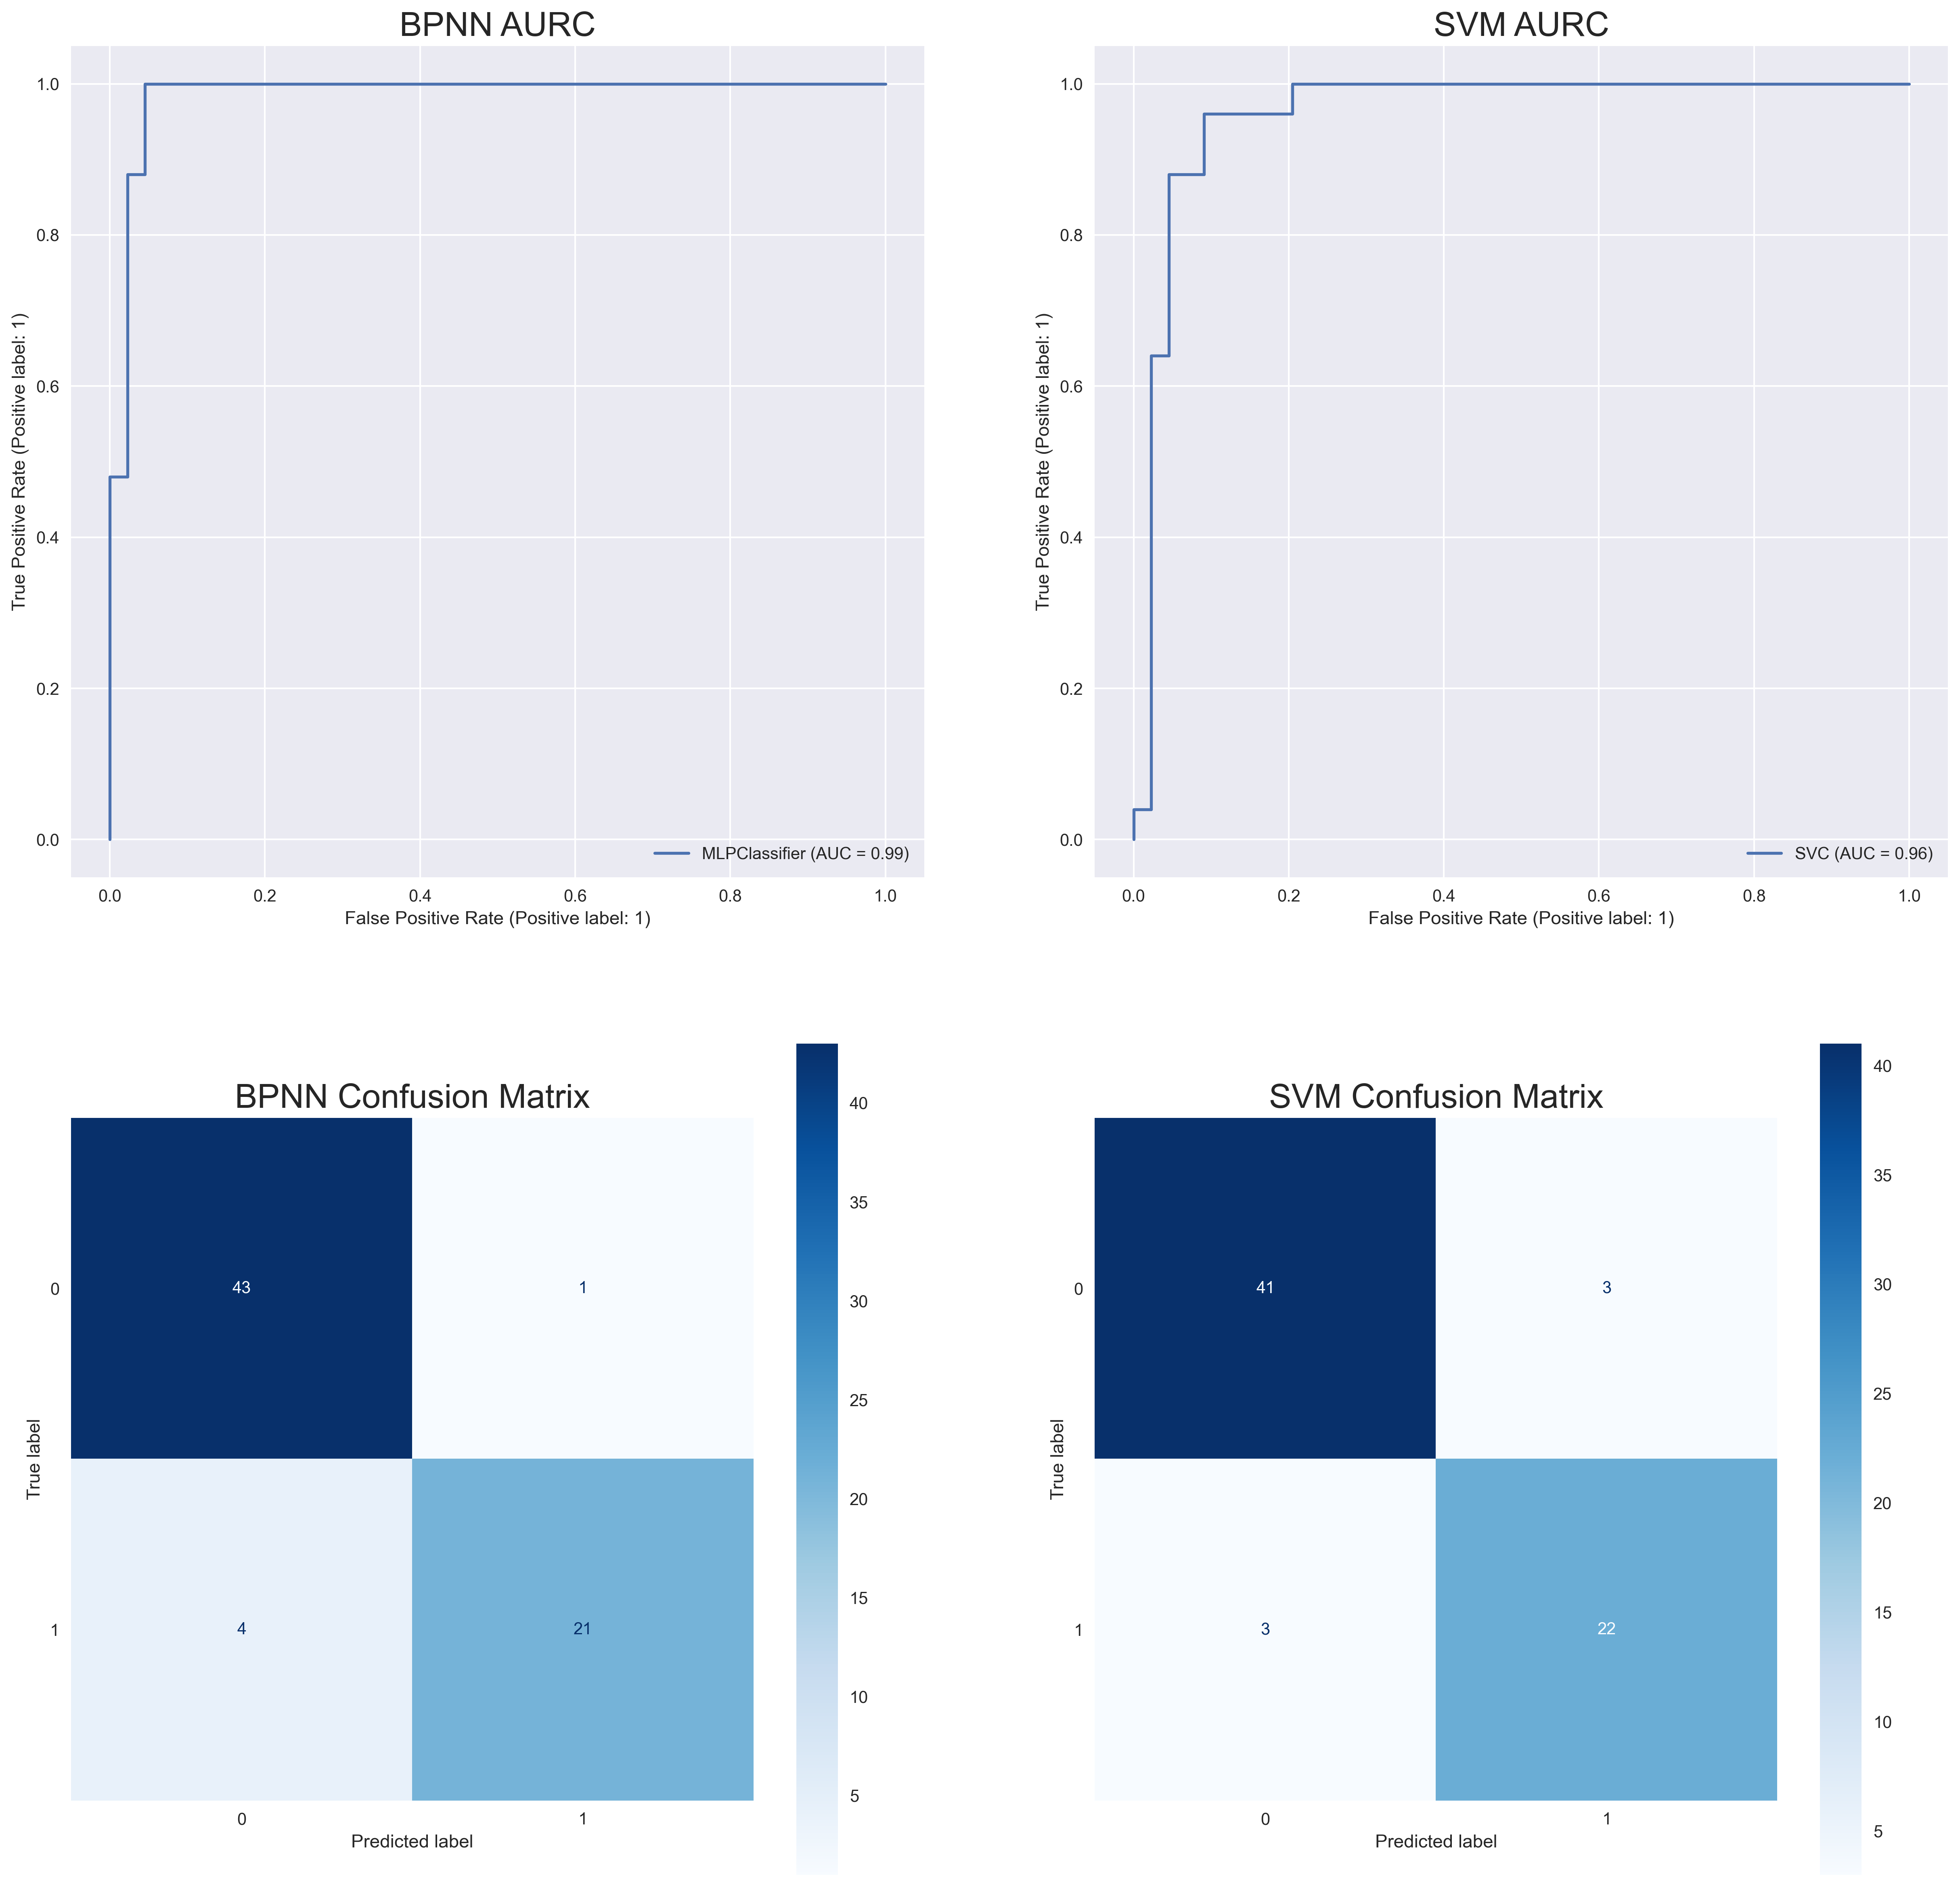

In [12]:
Grid_Search_model.training_report

In [13]:
pd.set_option("display.max_columns", None)
cv_obj = Grid_Search_model.cv_results()

# 訓練結果產出

In [14]:
class TrainingResult:
    def __init__(self, cv_obj):
        self.data = cv_obj
        
        self.svm = self.data["SVM"]
        self.bpnn = self.data["BPNN"]
    

In [15]:
pivot_report = TrainingResult(cv_obj= cv_obj)
pivot_report.bpnn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_random_state,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,split7_test_roc_auc,split8_test_roc_auc,split9_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.062832,0.013869,0.006283,0.000457,0.1,8,constant,0.1,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 8, 'learn...",0.821429,0.857143,0.857143,0.928571,0.888889,0.777778,0.962963,0.888889,0.962963,0.962963,0.890873,0.060752,155,0.918699,0.910569,0.902439,0.902439,0.906883,0.919028,0.902834,0.894737,0.898785,0.898785,0.905520,0.007853,0.938889,0.95,0.972222,0.972222,0.923529,0.941176,0.994118,0.981481,0.993827,0.981481,0.964895,0.023496,11,0.972096,0.971662,0.969710,0.966674,0.973348,0.970761,0.967313,0.967624,0.965552,0.965838,0.969058,0.002668
1,0.047273,0.011936,0.006084,0.000537,0.1,8,constant,0.2,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 8, 'learn...",0.821429,0.821429,0.857143,0.928571,0.888889,0.851852,0.962963,0.851852,0.962963,0.962963,0.891005,0.055537,153,0.906504,0.902439,0.898374,0.906504,0.902834,0.898785,0.902834,0.894737,0.906883,0.898785,0.901868,0.003904,0.938889,0.95,0.966667,0.972222,0.923529,0.929412,0.994118,0.981481,0.987654,0.981481,0.962545,0.024067,173,0.971517,0.971156,0.969999,0.966529,0.973132,0.971193,0.966739,0.967696,0.965695,0.965409,0.968906,0.002656
2,0.044182,0.008522,0.006184,0.000598,0.1,8,constant,0.3,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 8, 'learn...",0.821429,0.821429,0.892857,0.928571,0.888889,0.777778,0.888889,0.851852,0.925926,0.962963,0.876058,0.054426,242,0.914634,0.906504,0.914634,0.890244,0.906883,0.919028,0.890688,0.894737,0.890688,0.898785,0.902683,0.010516,0.933333,0.95,0.966667,0.972222,0.929412,0.929412,0.994118,0.975309,0.993827,0.981481,0.962578,0.024112,166,0.971228,0.972023,0.969999,0.966746,0.972917,0.970977,0.967457,0.967410,0.965695,0.965909,0.969036,0.002546
3,0.046077,0.009116,0.006383,0.000797,0.1,8,constant,0.4,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 8, 'learn...",0.821429,0.892857,0.892857,0.928571,0.851852,0.814815,0.925926,0.888889,0.925926,0.962963,0.890608,0.046062,167,0.914634,0.902439,0.882114,0.886179,0.902834,0.902834,0.890688,0.898785,0.890688,0.886640,0.895784,0.009606,0.933333,0.95,0.966667,0.972222,0.923529,0.929412,0.994118,0.981481,0.987654,0.981481,0.961990,0.024663,212,0.971156,0.971590,0.970433,0.966818,0.972989,0.971049,0.967457,0.967767,0.965623,0.965838,0.969072,0.002520
4,0.036702,0.015183,0.006283,0.000638,0.1,8,constant,0.5,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 8, 'learn...",0.821429,0.857143,0.892857,0.928571,0.888889,0.814815,0.962963,0.962963,0.962963,0.962963,0.905556,0.056397,18,0.914634,0.906504,0.906504,0.898374,0.906883,0.910931,0.898785,0.906883,0.902834,0.886640,0.903897,0.007428,0.933333,0.95,0.972222,0.972222,0.923529,0.929412,0.994118,0.975309,0.987654,0.981481,0.961928,0.024419,220,0.971156,0.971590,0.969349,0.965590,0.973060,0.970618,0.967170,0.967196,0.964837,0.965838,0.968640,0.002736
...,...,...,...,...,...,...,...,...,...,..

# SVM

# 準確度

In [16]:
pd.pivot_table(data= pivot_report.svm, columns= "param_C", 
               index = "param_tol", 
               values = "mean_test_accuracy")

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,0.897751,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.894180,0.894180,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905
0.000010,0.897751,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.894180,0.894180,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905
0.000100,0.897751,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.894180,0.894180,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905
0.001000,0.897751,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.894180,0.894180,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905,0.886905
0.010000,0.897751,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890608,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.890476,0.89047

In [17]:
pd.pivot_table(data= pivot_report.svm, columns= "param_C", 
               index = "param_tol", 
               values = "rank_test_accuracy")

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,1,18,18,18,18,18,18,18,18,18,6,6,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293
0.000010,1,18,18,18,18,18,18,18,18,18,6,6,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293
0.000100,1,18,18,18,18,18,18,18,18,18,6,6,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293
0.001000,1,18,18,18,18,18,18,18,18,18,6,6,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293
0.010000,1,18,18,18,18,18,18,18,18,18,18,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293,293
0.100000,18,18,18,6,18,287,18,6,18,18,72,72,287,18,6,536,72,6,72,72,72,72,72,72,536,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,289,72,293,72,72,72,293,72,72,72,289,293,72,72,72,72,72,538,289,538,538,293,293,289,72,538,293,542,72,72,293,72,293,293,534,293,293,542,72,293,534,293,542,293,293,542,542


# ROC-AUC

In [18]:
pd.pivot_table(data= pivot_report.svm, index= "param_C", 
               columns = "param_tol", 
               values = "rank_test_roc_auc").T

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,97,102,102,102,102,61,68,68,129,77,129,129,129,1,1,1,1,1,1,1,1,1,1,77,77,129,173,215,344,344,344,344,344,344,193,193,299,299,299,204,299,299,299,299,299,392,392,392,392,392,392,392,483,508,508,508,508,508,457,457,392,392,392,392,457,457,534,534,534,497,457,457,378,378,222,222,222,222,222,222,222,222,181,181,222,222,222,222,222,222,222
0.000010,97,102,102,102,102,61,68,68,129,77,129,129,129,1,1,1,1,1,1,1,1,1,1,77,77,129,173,215,344,344,344,344,344,344,193,193,299,299,299,204,299,299,299,299,299,392,392,392,392,392,392,392,483,508,508,508,508,508,457,457,392,392,392,392,457,457,534,534,534,497,457,457,378,378,222,222,222,222,222,222,222,222,181,181,222,222,222,222,222,222,222
0.000100,97,102,102,102,102,61,68,68,129,77,129,129,129,1,1,1,1,1,1,1,1,1,1,77,77,129,173,215,344,344,344,344,344,344,193,193,299,299,299,204,299,299,299,299,299,392,392,392,392,392,392,392,483,508,508,508,508,508,457,457,392,392,392,392,457,457,534,534,534,497,457,457,378,378,222,222,222,222,222,222,222,222,181,181,222,222,222,222,222,222,222
0.001000,97,102,102,102,102,61,68,68,129,77,129,129,129,1,1,1,1,1,1,1,1,1,1,77,77,129,173,215,344,344,344,344,344,344,193,193,299,299,299,204,299,299,299,299,299,392,392,392,392,392,392,392,483,508,508,508,508,508,508,392,392,392,392,392,392,497,534,534,497,497,457,457,378,378,378,222,222,222,222,222,222,222,181,181,222,222,222,222,222,222,222
0.010000,97,102,102,102,102,61,168,125,129,129,129,129,77,1,1,1,1,1,1,1,1,1,1,77,77,129,173,173,344,344,344,344,344,344,193,193,299,299,299,299,299,299,299,392,299,299,392,392,392,392,392,483,483,483,483,483,483,483,483,392,483,392,392,392,392,392,497,497,497,497,457,378,378,378,378,222,222,222,222,222,222,222,378,222,222,222,222,222,222,222,222
0.100000,60,102,102,61,59,165,125,125,125,129,68,129,1,1,1,1,1,1,77,77,1,77,124,129,77,171,158,193,77,344,299,455,169,204,1,344,173,67,204,129,169,204,392,457,344,344,204,166,204,204,171,508,455,215,204,299,392,457,220,299,166,222,392,220,508,299,392,457,162,181,508,457,496,181,532,546,534,532,497,181,222,457,454,162,181,298,180,162,159,159,159


In [19]:
pd.pivot_table(data= pivot_report.svm, index= "param_C", 
               columns = "param_tol", 
               values = "mean_test_roc_auc").T

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,0.951412,0.951351,0.951351,0.951351,0.951351,0.951939,0.951910,0.951910,0.951293,0.951881,0.951293,0.951293,0.951293,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.951881,0.951881,0.951293,0.950675,0.950120,0.949532,0.949532,0.949532,0.949532,0.949532,0.949532,0.950149,0.950149,0.949561,0.949561,0.949561,0.950149,0.949561,0.949561,0.949561,0.949561,0.949561,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948355,0.947767,0.947767,0.947767,0.947767,0.947767,0.948384,0.948384,0.948972,0.948972,0.948972,0.948972,0.948384,0.948384,0.947208,0.947208,0.947208,0.947796,0.948384,0.948384,0.949001,0.949001,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.94959,0.949590,0.950178,0.950178,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590
0.000010,0.951412,0.951351,0.951351,0.951351,0.951351,0.951939,0.951910,0.951910,0.951293,0.951881,0.951293,0.951293,0.951293,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.951881,0.951881,0.951293,0.950675,0.950120,0.949532,0.949532,0.949532,0.949532,0.949532,0.949532,0.950149,0.950149,0.949561,0.949561,0.949561,0.950149,0.949561,0.949561,0.949561,0.949561,0.949561,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948355,0.947767,0.947767,0.947767,0.947767,0.947767,0.948384,0.948384,0.948972,0.948972,0.948972,0.948972,0.948384,0.948384,0.947208,0.947208,0.947208,0.947796,0.948384,0.948384,0.949001,0.949001,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.94959,0.949590,0.950178,0.950178,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590
0.000100,0.951412,0.951351,0.951351,0.951351,0.951351,0.951939,0.951910,0.951910,0.951293,0.951881,0.951293,0.951293,0.951293,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.951881,0.951881,0.951293,0.950675,0.950120,0.949532,0.949532,0.949532,0.949532,0.949532,0.949532,0.950149,0.950149,0.949561,0.949561,0.949561,0.950149,0.949561,0.949561,0.949561,0.949561,0.949561,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948355,0.947767,0.947767,0.947767,0.947767,0.947767,0.948384,0.948384,0.948972,0.948972,0.948972,0.948972,0.948384,0.948384,0.947208,0.947208,0.947208,0.947796,0.948384,0.948384,0.949001,0.949001,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.94959,0.949590,0.950178,0.950178,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590
0.001000,0.951412,0.951351,0.951351,0.951351,0.951351,0.951939,0.951910,0.951910,0.951293,0.951881,0.951293,0.951293,0.951293,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.951881,0.951881,0.951293,0.950675,0.950120,0.949532,0.949532,0.949532,0.949532,0.949532,0.949532,0.950149,0.950149,0.949561,0.949561,0.949561,0.950149,0.949561,0.949561,0.949561,0.949561,0.949561,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.948355,0.947767,0.947767,0.947767,0.947767,0.947767,0.947767,0.948972,0.948972,0.948972,0.948972,0.948972,0.948972,0.947796,0.947208,0.947208,0.947796,0.947796,0.948384,0.948384,0.949001,0.949001,0.949001,0.949590,0.949590,0.949590,0.949590,0.949590,0.94959,0.949590,0.950178,0.950178,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590,0.949590
0.010000,0.951412,0.951351,0.951351,0.951351,0.951351,0.951939,0.950733,0.951322,0.951293,0.951293,0.951293,0.951293,0.951881,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.952469,0.

# BPNN

# 準確度

In [20]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "mean_test_accuracy")

param_hidden_layer_sizes                    4         8         16
param_learning_rate_init param_alpha                              
0.1                      0.1          0.898280  0.890873  0.898148
                         0.2          0.898280  0.905423  0.898280
                         0.3          0.898280  0.901852  0.898280
                         0.4          0.894577  0.898148  0.894577
                         0.5          0.894577  0.898016  0.894577
...                                        ...       ...       ...
1.0                      0.6          0.887037  0.853704  0.879630
                         0.7          0.887169  0.887037  0.894312
                         0.8          0.894180  0.890608  0.872222
                         0.9          0.901720  0.865212  0.894841
                         1.0          0.865873  0.857540  0.861376

[100 rows x 3 columns]

In [21]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "mean_test_accuracy")

param_hidden_layer_sizes                    4         8         16
param_learning_rate_init param_alpha                              
0.1                      0.1          0.898280  0.890873  0.898148
                         0.2          0.898280  0.905423  0.898280
                         0.3          0.898280  0.901852  0.898280
                         0.4          0.894577  0.898148  0.894577
                         0.5          0.894577  0.898016  0.894577
...                                        ...       ...       ...
1.0                      0.6          0.887037  0.853704  0.879630
                         0.7          0.887169  0.887037  0.894312
                         0.8          0.894180  0.890608  0.872222
                         0.9          0.901720  0.865212  0.894841
                         1.0          0.865873  0.857540  0.861376

[100 rows x 3 columns]

# ROC-AUC

In [22]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "mean_test_roc_auc")

param_hidden_layer_sizes                    4         8         16
param_learning_rate_init param_alpha                              
0.1                      0.1          0.961928  0.964895  0.962484
                         0.2          0.961928  0.964277  0.962484
                         0.3          0.962516  0.963072  0.963072
                         0.4          0.961961  0.963072  0.963627
                         0.5          0.963072  0.963627  0.964183
...                                        ...       ...       ...
1.0                      0.6          0.962516  0.963627  0.964248
                         0.7          0.965294  0.965294  0.962516
                         0.8          0.958562  0.962353  0.963072
                         0.9          0.962451  0.963627  0.961311
                         1.0          0.962026  0.963043  0.957810

[100 rows x 3 columns]

In [23]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "rank_test_roc_auc")

param_hidden_layer_sizes               4    8    16
param_learning_rate_init param_alpha               
0.1                      0.1          220   11  190
                         0.2          220   23  190
                         0.3          174  114  114
                         0.4          215  114   61
                         0.5          114   61   34
...                                   ...  ...  ...
1.0                      0.6          174   61   25
                         0.7            9    9  174
                         0.8          297  207  114
                         0.9          198   61  280
                         1.0          210  143  298

[100 rows x 3 columns]